<a href="https://colab.research.google.com/github/Aggie2024/Classification_Projects/blob/main/Car_Insurance_Project_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comparing the model performance with and without engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
# Define custom functions
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

The outcome column indicates 1 if a customer has claimed his/her claim else 0. The data has 19 features from there 18 of them are corresponding logs which were taken by the company.

In [3]:
# Save the filepath as a variable "fpath"
fpath =  "/content/drive/MyDrive/CodingDojo/Project_CarInsurance/Car_Insurance_Claim.csv"
# Read in the file and display the data
df = pd.read_csv(fpath)
# make customer id the index
df=df.set_index('ID')
# preview of the data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   AGE                  object 
 1   GENDER               object 
 2   RACE                 object 
 3   DRIVING_EXPERIENCE   object 
 4   EDUCATION            object 
 5   INCOME               object 
 6   CREDIT_SCORE         float64
 7   VEHICLE_OWNERSHIP    float64
 8   VEHICLE_YEAR         object 
 9   MARRIED              float64
 10  CHILDREN             float64
 11  POSTAL_CODE          int64  
 12  ANNUAL_MILEAGE       float64
 13  VEHICLE_TYPE         object 
 14  SPEEDING_VIOLATIONS  int64  
 15  DUIS                 int64  
 16  PAST_ACCIDENTS       int64  
 17  OUTCOME              float64
dtypes: float64(6), int64(4), object(8)
memory usage: 1.4+ MB


,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   AGE                  object 
 1   GENDER               object 
 2   RACE                 object 
 3   DRIVING_EXPERIENCE   object 
 4   EDUCATION            object 
 5   INCOME               object 
 6   CREDIT_SCORE         float64
 7   VEHICLE_OWNERSHIP    float64
 8   VEHICLE_YEAR         object 
 9   MARRIED              float64
 10  CHILDREN             float64
 11  POSTAL_CODE          int64  
 12  ANNUAL_MILEAGE       float64
 13  VEHICLE_TYPE         object 
 14  SPEEDING_VIOLATIONS  int64  
 15  DUIS                 int64  
 16  PAST_ACCIDENTS       int64  
 17  OUTCOME              float64
dtypes: float64(6), int64(4), object(8)
memory usage: 1.4+ MB


## 1. Use KMeans to create various customer segments

In [5]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = df.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA
# Save list of column names
ohe_cols = df.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                     verbose_feature_names_out=False)

Numeric Columns: Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')
OneHotEncoder Columns: Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object')


In [6]:
# fit and transform df
X_scaled = preprocessor.fit_transform(df)
X_scaled.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,AGE_16-25,AGE_26-39,AGE_40-64,AGE_65+,GENDER_female,GENDER_male,RACE_majority,RACE_minority,DRIVING_EXPERIENCE_0-9y,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_high school,EDUCATION_none,EDUCATION_university,INCOME_middle class,INCOME_poverty,INCOME_upper class,INCOME_working class,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
569520,0.858800,0.659333,-0.996406,0.672161,-0.508946,0.102181,-0.661462,-0.43102,-0.639263,-0.675455,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
750365,-1.215536,-1.516684,-0.996406,-1.487739,-0.508946,1.593875,-0.661462,-0.43102,-0.639263,1.480483,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
199901,-0.180252,0.659333,-0.996406,-1.487739,-0.508946,-0.270742,-0.661462,-0.43102,-0.639263,-0.675455,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
478866,-2.375887,0.659333,-0.996406,0.672161,0.682034,-0.270742,-0.661462,-0.43102,-0.639263,-0.675455,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
731664,-0.981478,0.659333,-0.996406,-1.487739,0.682034,0.102181,0.230657,-0.43102,-0.034072,1.480483,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


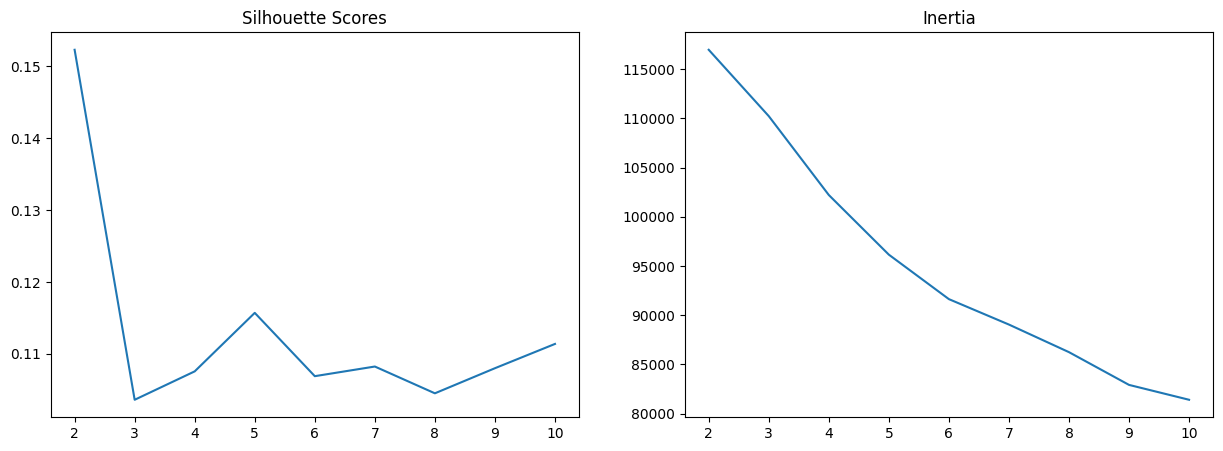

In [7]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(X_scaled)
  sils.append(silhouette_score(X_scaled, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

The highest silhouette score happens at 3 and there also an elbow at 3 - 4 in the inertia curve. We shall select 3 clusters for our model.

In [9]:
# Refit KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, n_init= 'auto', random_state=42)
kmeans.fit_predict(X_scaled)
pred = kmeans.predict(X_scaled)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,cluster
ID,,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0,3
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0,2
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0,2
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0,0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0,2


In [10]:
# Value count of points in each of the above-formed clusters
df['cluster'].value_counts()

cluster
3    3622
2    2308
0    1868
1    1721
4     481
Name: count, dtype: int64

K-means clusters our data into 5 clusters with the number of clients as indicated above.